In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_sin_data(num_training, num_testing, std_noise=0.1):
    X_train = np.random.uniform(-1.5, 1.5, num_training)
    Y_train = np.sin(np.pi * X_train) + np.random.randn(num_training) * std_noise
    X_train = np.reshape(X_train, [num_training, 1])
    Y_train = np.reshape(Y_train, [num_training, 1])

    X_test = np.linspace(-2., 2., num_testing)[:, None]

    return X_train, Y_train, X_test

num_training = 20
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

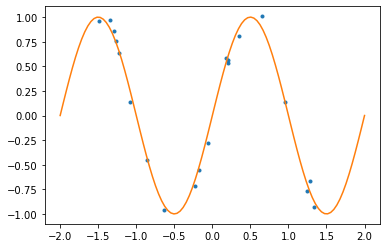

In [3]:
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

In [4]:
import sys 
sys.path.append("..") 
import tensorflow as tf

from dgp import DGP_RF
from likelihoods import Gaussian


class ToyRegressionDGP(DGP_RF):
    def __init__(self, d_in, d_out, n_hidden_layers=1, n_rf=20, n_gp=2, likelihood=Gaussian(),
                 kernel_list=None, random_fixed=True, name=None):
        super(ToyRegressionDGP, self).__init__(d_in, d_out, n_hidden_layers=n_hidden_layers,
                                            n_rf=n_rf, n_gp=n_gp,
                                            likelihood=likelihood, kernel_list=kernel_list,
                                            random_fixed=random_fixed, name=name)

    def feed_forward(self, X):
        X = tf.constant(X, tf.float32)
        # output mean because of the Gaussian likelihood in the final layer
        out = self.BNN(X)
        return out
    
    def feed_forward_all_layers(self, X):
        X = tf.constant(X, dtype=tf.float32)
        output_list = []
        for l, layer in enumerate(self.BNN.layers):
            X = layer(X)
            if l % 2 == 1:
                output_list.append(X)
        return output_list

    def adjust_traditional_learning_rate(self, epoch, lr_0=0.5, dtype=tf.float32):
        epoch = tf.cast(epoch, dtype)
        lr = lr_0
#         lr = 0.5 * (1. + epoch) ** (-0.5) * lr_0
        return lr

    def adjust_cyclical_learning_rate(self, epoch, K, M, lr_0=0.5):
        """
        using cyclical lr schedule
        :param epoch: current epoch index
        :param K: total iterations
        :param M: Number of cycles
        :param lr_0: initial learning rate
        """
        cos_inner = tf.constant(np.pi) / (K // M) * (epoch % (K // M))
        cos_out = tf.math.cos(cos_inner) + 1
        lr = 0.5 * lr_0 * cos_out
        return lr

Metal device set to: Apple M1 Pro


2022-06-07 00:07:49.505441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 00:07:49.505575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


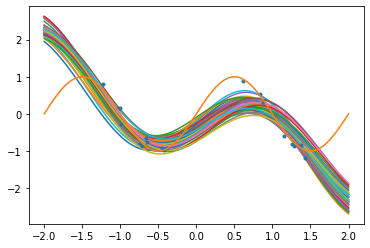

In [5]:
num_training = 20
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=50, n_gp=1, likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 10000
num_samples = 50
eta = 0.9

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward(X_test)
        out_samples.append(out)

out_samples = tf.concat(out_samples, axis=-1).numpy() #[N, num_samples]
# print(out_samples)


plt.plot(X_test, out_samples)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

In [6]:
model.trainable_variables

(<tf.Variable 'GP layer W:0' shape=(100, 1) dtype=float32, numpy=
 array([[-1.017168  ],
        [ 0.49837667],
        [ 1.3207568 ],
        [ 1.3764988 ],
        [-0.10423411],
        [-1.2491252 ],
        [-1.010945  ],
        [-0.3322207 ],
        [-0.2201041 ],
        [ 1.183282  ],
        [-1.4730994 ],
        [ 0.4900816 ],
        [ 0.59841883],
        [ 0.35106325],
        [-0.26014566],
        [ 1.4482008 ],
        [-0.11931722],
        [-0.00834195],
        [-0.7099318 ],
        [-1.2879758 ],
        [-0.00922386],
        [ 2.440212  ],
        [-1.4629917 ],
        [-0.54952633],
        [ 1.1170832 ],
        [-0.31864172],
        [ 0.6824923 ],
        [ 0.05853713],
        [-0.48749942],
        [-2.4414685 ],
        [ 0.32471412],
        [-0.23677179],
        [-1.1551021 ],
        [ 0.344936  ],
        [ 0.06593262],
        [-0.00265099],
        [-0.32436222],
        [ 0.8610565 ],
        [ 0.14106332],
        [ 1.6493627 ],
        [ 0.73

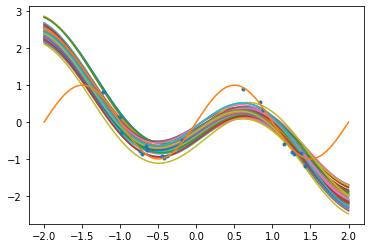

In [11]:
plt.plot(X_test, out_samples)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))
plt.savefig("sin-1-layer.png")

 ...]

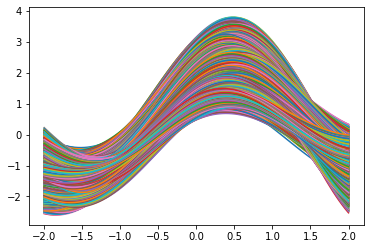

In [5]:
num_training = 20
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=50, n_gp=[1,1], likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 20000
num_samples = 10000
eta = 0.9

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.02)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
# plt.plot(X_train[:,0], Y_train[:,0], ".")
# plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

In [ ]:
num_mixing_epoches = 1
num_samples = 10000
eta = 0.9

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.02)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
# plt.plot(X_train[:,0], Y_train[:,0], ".")
# plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

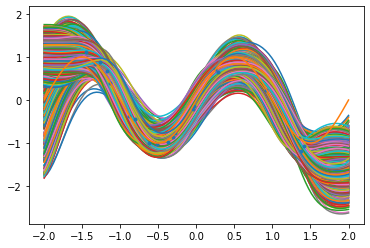

In [45]:
plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

[[ 0.1487246   0.14879657  0.14881597 ...  0.17394364  0.17392284
   0.17392147]
 [ 0.13877414  0.13884804  0.13886638 ...  0.16384104  0.16381885
   0.16381645]
 [ 0.12823644  0.12831214  0.12832932 ...  0.15314275  0.1531192
   0.15311578]
 ...
 [-0.17989337 -0.17989686 -0.1798994  ... -0.18566416 -0.18562898
  -0.18563479]
 [-0.18637894 -0.18638177 -0.18638483 ... -0.19183937 -0.19180453
  -0.19181052]
 [-0.19236308 -0.19236532 -0.19236884 ... -0.19751424 -0.19747986
  -0.19748595]]


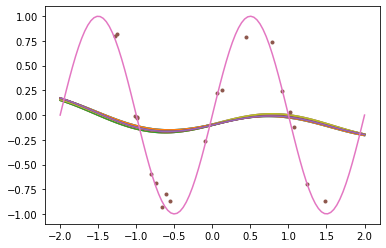

In [9]:
num_training = 20
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=30, n_gp=1, likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

alpha = 0.9

total_epoches = 10000 #K
M = 5
K_M = total_epoches // M

out_samples = []
for epoch in range(total_epoches):
    lr = model.adjust_cyclical_learning_rate(epoch, total_epoches, M, lr_0=0.1)
    model.sghmc_update(X_train, Y_train, lr, num_training, alpha=alpha,
                       epoch=epoch, epoch_per_cycle=K_M, num_samples_per_cycle=100,
                       temperature=1./num_training)
    if epoch % K_M + 1 > K_M - 3: # 3 samples per cycle
        out = model.feed_forward(X_test)
        out_samples.append(out)

out_samples = tf.concat(out_samples, axis=-1).numpy()  # [N, num_samples]

print(out_samples)

plt.plot(X_test, out_samples)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))